# Content
- [Aims](#Aims)
- [Helper Functions](#Helper-Functions)
- [Import Data](#Import-Data)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Data Splitting](#Data-Splitting)
- [Models](#Models)
- [ANOVA](#ANOVA)
- [Model Selection](#Model-Selection)
- [Model Evaluation](#Model-Evaluation)
- [Interpretation](#Interpretation)
- [Conclusion](#Conclusion)
- [Further Work](#Further-Work)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy import stats

from statsmodels.stats.stattools import durbin_watson

import warnings
warnings.filterwarnings('ignore')

# Aims

Construct a Gamma regression model to see if it better fits the underlying distribution.

# Helper Functions

In [2]:
def Gamma_shape(model, y, max_iter = 10, max_eps = 1e-4):
    
    from scipy.special import polygamma
    
    prior_weights = np.ones(len(y))
    fitted_value = model.fittedvalues
    Dbar = model.deviance / model.df_resid
    alpha = (6+2*Dbar)/(Dbar*(6+Dbar))
    
    fixed = -y/fitted_value - np.log(fitted_value) + np.log(prior_weights) + 1 + np.log(y + (y==0)*1)
    eps = 1
    itr = 0
    
    
    while ((np.abs(eps) > max_eps) & (itr < max_iter)):
        sc = np.sum(prior_weights * (fixed + np.log(alpha) - polygamma(0, prior_weights * alpha)))
        inf = np.sum(prior_weights * (prior_weights * polygamma(1, prior_weights*alpha) - 1 / alpha))
        eps = sc / inf
        alpha += eps
        
        itr += 1
    return (alpha, np.sqrt(1/inf))
# Credit: https://github.com/cran/MASS/blob/master/R/gamma.shape.R

In [3]:
def Forward_Selection(X, y, alpha = 0.05):
    glm = sm.GLM(y, np.ones(len(X)), family = sm.families.Gamma(link = sm.families.links.log())).fit()
    dispersion = Gamma_shape(glm, y)[0]
    dispersion = 1/dispersion
    prev_scaled_deviance = glm.deviance/dispersion
        
    selected_list = []
    remaining_list = X.columns.tolist().copy()
    selected = None
    p_value = None
    for i in range(X.shape[1]):
        deviance_min = np.inf
        for col in remaining_list:
            cols = selected_list.copy()
            cols.append(col)
            glm = sm.GLM(y, sm.add_constant(X[cols]), family = sm.families.Gamma(link = sm.families.links.log())).fit()
            dispersion = Gamma_shape(glm, y)[0]
            dispersion = 1/dispersion
            scaled_deviance = glm.deviance/dispersion
            if deviance_min > scaled_deviance:
                deviance_min = scaled_deviance
                selected = col
        
        test_statistic = prev_scaled_deviance - deviance_min
        p_value = stats.chi2.sf(test_statistic, df = 1)
        

        if p_value < alpha:
            selected_list.append(selected)
            remaining_list.remove(selected)
            prev_scaled_deviance = deviance_min
                
        else:
            return selected_list

In [4]:
def Backward_Elimination(X, y, alpha = 0.10):
    glm = sm.GLM(y, sm.add_constant(X), family = sm.families.Gamma(link = sm.families.links.log())).fit()
    dispersion = Gamma_shape(glm, y)[0]
    dispersion = 1/dispersion
    prev_scaled_deviance = glm.deviance/dispersion
        
    remaining_list = X.columns.tolist().copy()
    removed = None
    p_value = None
    for i in range(X.shape[1]):
        deviance_min = np.inf
        for col in remaining_list:
            cols = remaining_list.copy()
            cols.remove(col)
            glm = sm.GLM(y, sm.add_constant(X[cols]), family = sm.families.Gamma(link = sm.families.links.log())).fit()
            dispersion = Gamma_shape(glm, y)[0]
            dispersion = 1/dispersion
            scaled_deviance = glm.deviance/dispersion
            if deviance_min > scaled_deviance:
                deviance_min = scaled_deviance
                removed = col
            
        test_statistic = deviance_min - prev_scaled_deviance
        p_value = stats.chi2.sf(test_statistic, df = 1)

        if p_value >= alpha:
            remaining_list.remove(removed)
            prev_scaled_deviance = deviance_min
                
        else:
            return remaining_list

In [5]:
def Stepwise_Regression(X, y, alpha_in = 0.05, alpha_out = 0.10):
    glm = sm.GLM(y, np.ones(len(X)), family = sm.families.Gamma(link = sm.families.links.log())).fit()
    dispersion = Gamma_shape(glm, y)[0]
    dispersion = 1/dispersion
    prev_scaled_deviance = glm.deviance/dispersion
        
    remaining_list = X.columns.tolist().copy()
    selected_list = []
    selected = None
    removed = None
    p_value_in = None
    p_value_out = None
      
    while len(remaining_list) != 0:
        deviance_min = np.inf
        for col in remaining_list:
            cols = selected_list.copy()
            cols.append(col)
            
            glm = sm.GLM(y, sm.add_constant(X[cols]), family = sm.families.Gamma(link = sm.families.links.log())).fit()
            dispersion = Gamma_shape(glm, y)[0]
            dispersion = 1/dispersion
            scaled_deviance = glm.deviance/dispersion
                      
            if deviance_min > scaled_deviance:
                selected = col
                deviance_min = scaled_deviance
                
        test_statistic = prev_scaled_deviance - deviance_min
        p_value = stats.chi2.sf(test_statistic, df = 1)
        
        
        if p_value < alpha_in:
            selected_list.append(selected)
            remaining_list.remove(selected)
            prev_scaled_deviance = deviance_min
                
        else:
            return selected_list
        
        deviance_min = np.inf
        for col in selected_list:
            cols = selected_list.copy()
            cols.remove(col)
            
            if len(cols) == 0:
                glm = sm.GLM(y, np.ones(len(X)), family = sm.families.Gamma(link = sm.families.links.log())).fit()
            else:
                glm = sm.GLM(y, sm.add_constant(X[cols]), family = sm.families.Gamma(link = sm.families.links.log())).fit()
            
            dispersion = Gamma_shape(glm, y)[0]
            dispersion = 1/dispersion
            scaled_deviance = glm.deviance/dispersion
            
            if deviance_min > scaled_deviance:
                removed = col
                deviance_min = scaled_deviance
        
        test_statistic = deviance_min - prev_scaled_deviance
        p_value = stats.chi2.sf(test_statistic, df = 1)        
        
        if p_value >= alpha_out:
            selected_list.remove(removed)
            remaining_list.append(removed)
            prev_scaled_deviance = deviance_min

In [6]:
def Model_Diagnostic(model, X, date):
    model_xb = sm.add_constant(X).values @ model.params.values
    deviance_residuals = model.resid_deviance / np.sqrt(model.scale)
    
    data_time = pd.DataFrame({'Residual': deviance_residuals})
    data_time.index = date
    data_time = data_time.sort_values('Date')
    
    plt.figure(figsize=(10,10))
    
    plt.subplot(221)
    plt.hist(deviance_residuals)
    
    plt.subplot(222)
    stats.probplot(deviance_residuals, dist="norm", plot=plt)
    
    plt.subplot(223)
    sns.residplot(model_xb, deviance_residuals,
              lowess=True,
              scatter_kws={'alpha': 0.5},
              line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8})
    
    plt.subplot(224)
    plt.plot(data_time['Residual'].values)
    
    plt.show()

In [7]:
def Bootstrap(X, y, n = 1000, fit_intercept = True, random_state = 0):
    
    from sklearn.utils import shuffle
    
    rand_num = range(n)
    rand_num = shuffle(rand_num, random_state = random_state)
    
    
    if fit_intercept:
        X = sm.add_constant(X)
    
    coefs = np.zeros((n, X.shape[1]))
    
    for i in range(n):
        df = pd.concat([X, y], axis = 1)
        df_resample = df.sample(len(df), replace = True, random_state = rand_num[i])
        
        X_resample = df_resample.iloc[:, :X.shape[1]]
        y_resample = df_resample.iloc[:, -1]
        
        
        model = sm.GLM(y_resample, X_resample, family = sm.families.Gamma(link = sm.families.links.log())).fit()
        
        coefs[i, :] = model.params.values

    model = sm.GLM(y, X, family = sm.families.Gamma(link = sm.families.links.log())).fit()
    
    coefs = pd.DataFrame(coefs)
    result = pd.DataFrame()
    result['Original'] = model.params.values
    result['Bias'] = model.params.values - coefs.mean().values
    result['Standard Error'] = coefs.std(ddof = 1)
    result.index = X.columns
    
    return result

# Import Data

In [8]:
data = pd.read_csv('../../data/Avocado/avocado.csv', index_col = 0)
data.shape

(18249, 13)

In [9]:
data['Date'] = pd.to_datetime(data['Date'])
data.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


# Exploratory Data Analysis

In [10]:
alpha, loc, beta = stats.gamma.fit(data['AveragePrice'])

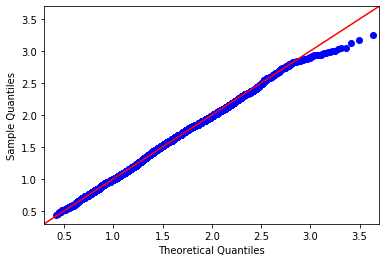

In [11]:
sm.ProbPlot(data['AveragePrice'], stats.gamma, distargs = (alpha, ), loc = loc, scale = beta).qqplot(line="45")
plt.show()
# Roughly fit gamma distribution except the right tail.

# Data Splitting

In [12]:
train, test = train_test_split(data, test_size = 0.25, random_state = 0)
train.shape, test.shape

((13686, 13), (4563, 13))

In [13]:
train, validate = train_test_split(train, test_size = 1/3, random_state = 0)
train.shape, validate.shape

((9124, 13), (4562, 13))

# Models

In [14]:
X = train[['4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'region', 'Date']]
y = train['AveragePrice']

X[['4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags']] /= 1e6
# Cannot be too large

X = X.rename(columns = {'Small Bags': 'Small_Bags',
                        'Large Bags': 'Large_Bags',
                        'XLarge Bags': 'XLarge_Bags'})

df = pd.get_dummies(X['type']).drop('conventional', axis = 1)
X = pd.concat([X, df], axis = 1).drop('type', axis = 1)

df = pd.get_dummies(X['region']).drop('HarrisburgScranton', axis = 1)
regions = df.columns.tolist()
X = pd.concat([X, df], axis = 1).drop('region', axis = 1)

X['season'] = ['Spring' if (x == 3 or x == 4 or x == 5) else
               'Summer' if (x == 6 or x == 7 or x == 8) else
               'Autumn' if (x == 9 or x == 10 or x == 11) else
               'Winter' for x in pd.DatetimeIndex(X['Date']).month]
X = X.drop('Date', axis = 1)

df = pd.get_dummies(X['season']).drop('Winter', axis = 1)
X = pd.concat([X, df], axis = 1).drop('season', axis = 1)

Small_Volume_type = ['4046_organic']
Intermediate_Volume_type = ['4225_organic']
Large_Volume_type = ['4770_organic']

Small_Bags_type = ['Small_Bags_organic']
Large_Bags_type = ['Large_Bags_organic']
XLarge_Bags_type = ['XLarge_Bags_organic']

X['4046_organic'] = X['4046'] * X['organic']
X['4225_organic'] = X['4225'] * X['organic']
X['4770_organic'] = X['4770'] * X['organic']

X['Small_Bags_organic'] = X['Small_Bags'] * X['organic']
X['Large_Bags_organic'] = X['Large_Bags'] * X['organic']
X['XLarge_Bags_organic'] = X['XLarge_Bags'] * X['organic']

Small_Volume_season = []
Intermediate_Volume_season = []
Large_Volume_season = []

Small_Volume_type_season = []
Intermediate_Volume_type_season = []
Large_Volume_type_season = []

Small_Bags_season = []
Large_Bags_season = []
XLarge_Bags_season = []

Small_Bags_type_season = []
Large_Bags_type_season = []
XLarge_Bags_type_season = []

type_season = []

for season in ['Spring', 'Summer', 'Autumn']:
    col_name = '4046' + '_' + season
    X[col_name] = X['4046'] * X[season]
    Small_Volume_season.append(col_name)
    col_name = '4225' + '_' + season
    X[col_name] = X['4225'] * X[season]
    Intermediate_Volume_season.append(col_name)
    col_name = '4770' + '_' + season
    X[col_name] = X['4770'] * X[season]
    Large_Volume_season.append(col_name)

    col_name = 'Small_Bags' + '_' + season
    X[col_name] = X['Small_Bags'] * X[season]
    Small_Bags_season.append(col_name)    
    col_name = 'Large_Bags' + '_' + season
    X[col_name] = X['Large_Bags'] * X[season]
    Large_Bags_season.append(col_name)
    col_name = 'XLarge_Bags' + '_' + season
    X[col_name] = X['XLarge_Bags'] * X[season]
    XLarge_Bags_season.append(col_name)
    
    col_name = 'organic' + '_' + season
    X[col_name] = X['organic'] * X[season]
    type_season.append(col_name)
    
    col_name = '4046' + '_' + 'organic' + '_' + season
    X[col_name] = X['4046'] * X['organic'] * X[season]
    Small_Volume_type_season.append(col_name)
    col_name = '4225' + '_' + 'organic' + '_' + season
    X[col_name] = X['4225'] * X['organic'] * X[season]
    Intermediate_Volume_type_season.append(col_name)
    col_name = '4770' + '_' + 'organic' + '_' + season
    X[col_name] = X['4770'] * X['organic'] * X[season] 
    Large_Volume_type_season.append(col_name)
        
    col_name = 'Small_Bags' + '_' + 'organic' + '_' + season
    X[col_name] = X['Small_Bags'] * X['organic'] * X[season]
    Small_Bags_type_season.append(col_name)
    col_name = 'Large_Bags' + '_' + 'organic' + '_' + season
    X[col_name] = X['Large_Bags'] * X['organic'] * X[season]
    Large_Bags_type_season.append(col_name)
    col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + season
    X[col_name] = X['XLarge_Bags'] * X['organic'] * X[season]  
    XLarge_Bags_type_season.append(col_name)        

Small_Volume_region = []
Intermediate_Volume_region = []
Large_Volume_region = []

Small_Volume_region_season = []
Intermediate_Volume_region_season = []
Large_Volume_region_season = []

Small_Volume_type_region = []
Intermediate_Volume_type_region = []
Large_Volume_type_region = []

Small_Volume_type_region_season = []
Intermediate_Volume_type_region_season = []
Large_Volume_type_region_season = []

Small_Bags_region = []
Large_Bags_region = []
XLarge_Bags_region = []

Small_Bags_region_season = []
Large_Bags_region_season = []
XLarge_Bags_region_season = []

Small_Bags_type_region = []
Large_Bags_type_region = []
XLarge_Bags_type_region = []

Small_Bags_type_region_season = []
Large_Bags_type_region_season = []
XLarge_Bags_type_region_season = []

type_region = []
region_season = []
type_region_season = []

for region in regions:
    col_name = '4046' + '_' + region
    X[col_name] = X['4046'] * X[region]
    Small_Volume_region.append(col_name)    
    col_name = '4225' + '_' + region
    X[col_name] = X['4225'] * X[region]
    Intermediate_Volume_region.append(col_name)    
    col_name = '4770' + '_' + region
    X[col_name] = X['4770'] * X[region]
    Large_Volume_region.append(col_name)
        
    col_name = 'Small_Bags' + '_' + region
    X[col_name] = X['Small_Bags'] * X[region]
    Small_Bags_region.append(col_name)
    col_name = 'Large_Bags' + '_' + region
    X[col_name] = X['Large_Bags'] * X[region]
    Large_Bags_region.append(col_name)
    col_name = 'XLarge_Bags' + '_' + region        
    X[col_name] = X['XLarge_Bags'] * X[region]
    XLarge_Bags_region.append(col_name)
        
    col_name = 'organic' + '_' + region
    X[col_name] = X['organic'] * X[region]
    type_region.append(col_name)
        
    col_name = '4046' + '_' + 'organic' + '_' + region
    X[col_name] = X['4046'] * X['organic'] * X[region]
    Small_Volume_type_region.append(col_name)
    col_name = '4225' + '_' + 'organic' + '_' + region
    X[col_name] = X['4225'] * X['organic'] * X[region]
    Intermediate_Volume_type_region.append(col_name)
    col_name = '4770' + '_' + 'organic' + '_' + region
    X[col_name] = X['4770'] * X['organic'] * X[region]
    Large_Volume_type_region.append(col_name)
        
    col_name = 'Small_Bags' + '_' + 'organic' + '_' + region
    X[col_name] = X['Small_Bags'] * X['organic'] * X[region]
    Small_Bags_type_region.append(col_name)
    col_name = 'Large_Bags' + '_' + 'organic' + '_' + region
    X[col_name] = X['Large_Bags'] * X['organic'] * X[region] 
    Large_Bags_type_region.append(col_name)
    col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + region
    X[col_name] = X['XLarge_Bags'] * X['organic'] * X[region] 
    XLarge_Bags_type_region.append(col_name)
    
    for season in ['Spring', 'Summer', 'Autumn']:
        col_name = region + '_' + season
        X[col_name] = X[region] * X[season]
        region_season.append(col_name)
        
        col_name = '4046' + '_' + region + '_' + season
        X[col_name] = X['4046'] * X[region] * X[season]
        Small_Volume_region_season.append(col_name)
        col_name = '4225' + '_' + region + '_' + season
        X[col_name] = X['4225'] * X[region] * X[season] 
        Intermediate_Volume_region_season.append(col_name)
        col_name = '4770' + '_' + region + '_' + season
        X[col_name] = X['4770'] * X[region] * X[season]
        Large_Volume_region_season.append(col_name)
        
        col_name = 'Small_Bags' + '_' + region + '_' + season
        X[col_name] = X['Small_Bags'] * X[region] * X[season]
        Small_Bags_region_season.append(col_name)
        col_name = 'Large_Bags' + '_' + region + '_' + season
        X[col_name] = X['Large_Bags'] * X[region] * X[season]
        Large_Bags_region_season.append(col_name)
        col_name = 'XLarge_Bags' + '_' + region + '_' + season
        X[col_name] = X['XLarge_Bags'] * X[region] * X[season]
        XLarge_Bags_region_season.append(col_name)
        
        col_name = 'organic' + '_' + region + '_' + season
        X[col_name] = X['organic'] * X[region] * X[season]
        type_region_season.append(col_name)
        
        col_name = '4046' + '_' + 'organic' + '_' + region + '_' + season
        X[col_name] = X['4046'] * X['organic'] * X[region] * X[season]
        Small_Volume_type_region_season.append(col_name)
        col_name = '4225' + '_' + 'organic' + '_' + region + '_' + season
        X[col_name] = X['4225'] * X['organic'] * X[region] * X[season] 
        Intermediate_Volume_type_region_season.append(col_name)
        col_name = '4770' + '_' + 'organic' + '_' + region + '_' + season
        X[col_name] = X['4770'] * X['organic'] * X[region] * X[season]  
        Large_Volume_type_region_season.append(col_name)
        
        col_name = 'Small_Bags' + '_' + 'organic' + '_' + region + '_' + season
        X[col_name] = X['Small_Bags'] * X['organic'] * X[region] * X[season]
        Small_Bags_type_region_season.append(col_name)
        col_name = 'Large_Bags' + '_' + 'organic' + '_' + region + '_' + season
        X[col_name] = X['Large_Bags'] * X['organic'] * X[region] * X[season]
        Large_Bags_type_region_season.append(col_name)
        col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + region + '_' + season
        X[col_name] = X['XLarge_Bags'] * X['organic'] * X[region] * X[season]  
        XLarge_Bags_type_region_season.append(col_name)

In [15]:
full_model = sm.GLM(y, sm.add_constant(X), family = sm.families.Gamma(link = sm.families.links.log())).fit()
full_model.summary()
# Using log as the link function as it is easier to interpret.

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           AveragePrice   No. Observations:                 9124
Model:                            GLM   Df Residuals:                     6378
Model Family:                   Gamma   Df Model:                         2745
Link Function:                    log   Scale:                       0.0094772
Method:                          IRLS   Log-Likelihood:                 6978.3
Date:                Wed, 24 Mar 2021   Deviance:                       60.309
Time:                        15:57:25   Pearson chi2:                     60.4
No. Iterations:                    14                                         
Covariance Type:            nonrobust                                         
==================================================================================================================
                                                     coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------------
const                                              0.4239      0.151      2.803      0.005       0.127       0.720
4046                                               0.2153      0.995      0.216      0.829      -1.735       2.165
4225                                              -0.8444      0.857     -0.985      0.325      -2.525       0.836
4770                                              39.5946     26.627      1.487      0.137     -12.593      91.782
Small_Bags                                        -2.4637      2.303     -1.070      0.285      -6.977       2.050
Large_Bags                                         6.8817      8.025      0.858      0.391      -8.847      22.610
XLarge_Bags                                        6.7419     57.058      0.118      0.906    -105.090     118.574
organic                                            0.2017      0.162      1.244      0.214      -0.116       0.520
Albany                                            -0.2595      0.182     -1.423      0.155      -0.617       0.098
Atlanta                                           -0.1747      0.185     -0.947      0.344      -0.536       0.187
BaltimoreWashington                                0.2379      0.205      1.161      0.246      -0.164       0.640
Boise                                             -0.3925      0.233     -1.682      0.093      -0.850       0.065
Boston                                            -0.1948      0.212     -0.919      0.358      -0.610       0.221
BuffaloRochester                                   0.0122      0.192      0.063      0.949      -0.365       0.389
California                                        -0.1639      0.195     -0.842      0.400      -0.545       0.218
Charlotte                                         -0.1320      0.277     -0.477      0.633      -0.674       0.410
Chicago                                            0.2041      0.223      0.917      0.359      -0.232       0.640
CincinnatiDayton                                  -0.4468      0.207     -2.156      0.031      -0.853      -0.041
Columbus                                          -0.2173      0.186     -1.169      0.242      -0.582       0.147
DallasFtWorth                                     -0.2429      0.228     -1.066      0.287      -0.690       0.204
Denver                                            -0.0693      0.192     -0.361      0.718      -0.446       0.307
Detroit                                           -0.0200      0.182     -0.110      0.913      -0.377       0.337
GrandRapids                                        0.1284      0.236      0.545      0.586      -0.334       0.591
GreatLakes                                        -0.1706      0.182     -0.938      0.348   

In [16]:
full_model_dispersion = Gamma_shape(full_model, y)[0]
full_model_dispersion = 1/full_model_dispersion
full_model_dispersion

0.006602681699388926

In [17]:
full_model.deviance/(full_model_dispersion * full_model.df_resid)
# A little bit lack of fit.

1.4321167190656996

# ANOVA

In [18]:
reduced_4_way = Small_Volume_type_region_season + Intermediate_Volume_type_region_season + Large_Volume_type_region_season + \
                Small_Bags_type_region_season + Large_Bags_type_region_season + XLarge_Bags_type_region_season

In [19]:
reduced_4_way_model = sm.GLM(y, sm.add_constant(X.drop(reduced_4_way, axis = 1)), family = sm.families.Gamma(link = sm.families.links.log())).fit()

In [20]:
reduced_4_way_model_dispersion = Gamma_shape(reduced_4_way_model, y)[0]
reduced_4_way_model_dispersion = 1/reduced_4_way_model_dispersion
reduced_4_way_model_dispersion

0.008731470151346116

In [21]:
chi_stat = reduced_4_way_model.deviance/reduced_4_way_model_dispersion - full_model.deviance/full_model_dispersion
df = reduced_4_way_model.df_resid - full_model.df_resid
critical_value = stats.chi.ppf(0.95, df = df)
p_value = stats.chi.sf(chi_stat, df)

print('Chi-square Statistic:', chi_stat)
print('Critical value:', critical_value)
print('p-value:', p_value)
# Not significant

Chi-square Statistic: 3.2371201855075924
Critical value: 28.325071044912796
p-value: 1.0


In [22]:
final_model = reduced_4_way_model
final_model_dispersion = reduced_4_way_model_dispersion

In [23]:
reduced_3_way = Small_Volume_type_region + Small_Volume_type_season + Small_Volume_region_season + \
                Intermediate_Volume_type_region + Intermediate_Volume_type_season + Intermediate_Volume_region_season +\
                Large_Volume_type_region + Large_Volume_type_season + Large_Volume_region_season +\
                Small_Bags_type_region + Small_Bags_type_season + Small_Bags_region_season +\
                Large_Bags_type_region + Large_Bags_type_season + Large_Bags_region_season +\
                XLarge_Bags_type_region + XLarge_Bags_type_season + XLarge_Bags_region_season +\
                type_region_season

In [24]:
reduced_3_way_model = sm.GLM(y, sm.add_constant(X.drop(reduced_4_way + reduced_3_way, axis = 1)), family = sm.families.Gamma(link = sm.families.links.log())).fit()

In [25]:
reduced_3_way_model_dispersion = Gamma_shape(reduced_3_way_model, y)[0]
reduced_3_way_model_dispersion = 1/reduced_3_way_model_dispersion
reduced_3_way_model_dispersion

0.017419417810213927

In [26]:
chi_stat = reduced_3_way_model.deviance/reduced_3_way_model_dispersion - final_model.deviance/final_model_dispersion
df = reduced_3_way_model.df_resid - final_model.df_resid
critical_value = stats.chi.ppf(0.95, df = df)
p_value = stats.chi.sf(chi_stat, df)

print('Chi-square Statistic:', chi_stat)
print('Critical value:', critical_value)
print('p-value:', p_value)
# Not significant

Chi-square Statistic: 13.210769970017282
Critical value: 38.402532048227535
p-value: 1.0


In [27]:
final_model = reduced_3_way_model
final_model_dispersion = reduced_3_way_model_dispersion

In [28]:
reduced_2_way = Small_Volume_type + Small_Volume_region + Small_Volume_season +\
                Intermediate_Volume_type + Intermediate_Volume_region + Intermediate_Volume_season +\
                Large_Volume_type + Large_Volume_region + Large_Volume_season +\
                Small_Bags_type + Small_Bags_region + Small_Bags_season +\
                Large_Bags_type + Large_Bags_region + Large_Bags_season +\
                XLarge_Bags_type + XLarge_Bags_region + XLarge_Bags_season +\
                type_season + type_region + region_season

In [29]:
reduced_2_way_model = sm.GLM(y, sm.add_constant(X.drop(reduced_4_way + reduced_3_way + reduced_2_way, axis = 1)), family = sm.families.Gamma(link = sm.families.links.log())).fit()

In [30]:
reduced_2_way_model_dispersion = Gamma_shape(reduced_2_way_model, y)[0]
reduced_2_way_model_dispersion = 1/reduced_2_way_model_dispersion
reduced_2_way_model_dispersion

0.03079566552297063

In [31]:
chi_stat = reduced_2_way_model.deviance/reduced_2_way_model_dispersion - final_model.deviance/final_model_dispersion
df = reduced_2_way_model.df_resid - final_model.df_resid
critical_value = stats.chi.ppf(0.95, df = df)
p_value = stats.chi.sf(chi_stat, df)

print('Chi-square Statistic:', chi_stat)
print('Critical value:', critical_value)
print('p-value:', p_value)
# Not significant

Chi-square Statistic: 20.337178460547875
Critical value: 24.75909900421264
p-value: 0.9999987758079345


In [32]:
final_model = reduced_2_way_model
final_model_dispersion = reduced_2_way_model_dispersion

## Comparison

In [33]:
def data_preprocessing(data, regions = regions):
    X = data[['4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'region', 'Date']]
    y = data['AveragePrice']

    X[['4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags']] /= 1e6
    
    X = X.rename(columns = {'Small Bags': 'Small_Bags',
                            'Large Bags': 'Large_Bags',
                            'XLarge Bags': 'XLarge_Bags'})

    df = pd.get_dummies(X['type']).drop('conventional', axis = 1)
    X = pd.concat([X, df], axis = 1).drop('type', axis = 1)

    df = pd.get_dummies(X['region']).drop('HarrisburgScranton', axis = 1)
    df = df[regions]
    X = pd.concat([X, df], axis = 1).drop('region', axis = 1)

    X['season'] = ['Spring' if (x == 3 or x == 4 or x == 5) else
                   'Summer' if (x == 6 or x == 7 or x == 8) else
                   'Autumn' if (x == 9 or x == 10 or x == 11) else
                   'Winter' for x in pd.DatetimeIndex(X['Date']).month]
    X = X.drop('Date', axis = 1)

    df = pd.get_dummies(X['season']).drop('Winter', axis = 1)
    X = pd.concat([X, df], axis = 1).drop('season', axis = 1)

    X['4046_organic'] = X['4046'] * X['organic']
    X['4225_organic'] = X['4225'] * X['organic']
    X['4770_organic'] = X['4770'] * X['organic']

    X['Small_Bags_organic'] = X['Small_Bags'] * X['organic']
    X['Large_Bags_organic'] = X['Large_Bags'] * X['organic']
    X['XLarge_Bags_organic'] = X['XLarge_Bags'] * X['organic']

    for season in ['Spring', 'Summer', 'Autumn']:
        col_name = '4046' + '_' + season
        X[col_name] = X['4046'] * X[season]
        col_name = '4225' + '_' + season
        X[col_name] = X['4225'] * X[season]        
        col_name = '4770' + '_' + season
        X[col_name] = X['4770'] * X[season]

        col_name = 'Small_Bags' + '_' + season
        X[col_name] = X['Small_Bags'] * X[season]  
        col_name = 'Large_Bags' + '_' + season
        X[col_name] = X['Large_Bags'] * X[season]
        col_name = 'XLarge_Bags' + '_' + season
        X[col_name] = X['XLarge_Bags'] * X[season]

        col_name = 'organic' + '_' + season
        X[col_name] = X['organic'] * X[season]

        col_name = '4046' + '_' + 'organic' + '_' + season
        X[col_name] = X['4046'] * X['organic'] * X[season]
        col_name = '4225' + '_' + 'organic' + '_' + season
        X[col_name] = X['4225'] * X['organic'] * X[season]
        col_name = '4770' + '_' + 'organic' + '_' + season
        X[col_name] = X['4770'] * X['organic'] * X[season] 

        col_name = 'Small_Bags' + '_' + 'organic' + '_' + season
        X[col_name] = X['Small_Bags'] * X['organic'] * X[season]
        col_name = 'Large_Bags' + '_' + 'organic' + '_' + season
        X[col_name] = X['Large_Bags'] * X['organic'] * X[season]
        col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + season
        X[col_name] = X['XLarge_Bags'] * X['organic'] * X[season]         

    for region in regions:
        col_name = '4046' + '_' + region
        X[col_name] = X['4046'] * X[region]   
        col_name = '4225' + '_' + region
        X[col_name] = X['4225'] * X[region]   
        col_name = '4770' + '_' + region
        X[col_name] = X['4770'] * X[region]

        col_name = 'Small_Bags' + '_' + region
        X[col_name] = X['Small_Bags'] * X[region]
        col_name = 'Large_Bags' + '_' + region
        X[col_name] = X['Large_Bags'] * X[region]
        col_name = 'XLarge_Bags' + '_' + region        
        X[col_name] = X['XLarge_Bags'] * X[region]

        col_name = 'organic' + '_' + region
        X[col_name] = X['organic'] * X[region]

        col_name = '4046' + '_' + 'organic' + '_' + region
        X[col_name] = X['4046'] * X['organic'] * X[region]
        col_name = '4225' + '_' + 'organic' + '_' + region
        X[col_name] = X['4225'] * X['organic'] * X[region]
        col_name = '4770' + '_' + 'organic' + '_' + region
        X[col_name] = X['4770'] * X['organic'] * X[region]

        col_name = 'Small_Bags' + '_' + 'organic' + '_' + region
        X[col_name] = X['Small_Bags'] * X['organic'] * X[region]
        col_name = 'Large_Bags' + '_' + 'organic' + '_' + region
        X[col_name] = X['Large_Bags'] * X['organic'] * X[region] 
        col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + region
        X[col_name] = X['XLarge_Bags'] * X['organic'] * X[region] 

        for season in ['Spring', 'Summer', 'Autumn']:
            col_name = region + '_' + season
            X[col_name] = X[region] * X[season]

            col_name = '4046' + '_' + region + '_' + season
            X[col_name] = X['4046'] * X[region] * X[season]
            col_name = '4225' + '_' + region + '_' + season
            X[col_name] = X['4225'] * X[region] * X[season] 
            col_name = '4770' + '_' + region + '_' + season
            X[col_name] = X['4770'] * X[region] * X[season]

            col_name = 'Small_Bags' + '_' + region + '_' + season
            X[col_name] = X['Small_Bags'] * X[region] * X[season]
            col_name = 'Large_Bags' + '_' + region + '_' + season
            X[col_name] = X['Large_Bags'] * X[region] * X[season]
            col_name = 'XLarge_Bags' + '_' + region + '_' + season
            X[col_name] = X['XLarge_Bags'] * X[region] * X[season]

            col_name = 'organic' + '_' + region + '_' + season
            X[col_name] = X['organic'] * X[region] * X[season]
            col_name = '4046' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['4046'] * X['organic'] * X[region] * X[season]
            col_name = '4225' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['4225'] * X['organic'] * X[region] * X[season] 
            col_name = '4770' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['4770'] * X['organic'] * X[region] * X[season]  

            col_name = 'Small_Bags' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['Small_Bags'] * X['organic'] * X[region] * X[season]
            col_name = 'Large_Bags' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['Large_Bags'] * X['organic'] * X[region] * X[season]
            col_name = 'XLarge_Bags' + '_' + 'organic' + '_' + region + '_' + season
            X[col_name] = X['XLarge_Bags'] * X['organic'] * X[region] * X[season]  

    return (X, y)

In [34]:
validate_X, validate_y = data_preprocessing(validate)

### BIC

In [35]:
print('Final Model', final_model.bic)

Final Model -82332.6703908885


In [36]:
print('Up to two-way interaction effect:', reduced_3_way_model.bic)
print('Up to three-way interaction effect:', reduced_4_way_model.bic)
print('Full model:', full_model.bic)
# In terms of BIC, final model performs the best as it has the lowest BIC

Up to two-way interaction effect: -77376.60027039713
Up to three-way interaction effect: -64808.62819327416
Full model: -58098.527173336115


### Validate MSE

In [37]:
print('Final Model:', mean_squared_error(validate_y, final_model.predict(sm.add_constant(validate_X.drop(reduced_4_way + reduced_3_way + reduced_2_way, axis = 1)))))

Final Model: 0.06814259714011996


In [38]:
print('Up to two-way interaction effect:', mean_squared_error(validate_y, reduced_3_way_model.predict(sm.add_constant(validate_X.drop(reduced_4_way + reduced_3_way, axis = 1)))))
print('Up to three-way interaction effect:', mean_squared_error(validate_y, reduced_4_way_model.predict(sm.add_constant(validate_X.drop(reduced_4_way, axis = 1)))))
print('Full model:', mean_squared_error(validate_y, full_model.predict(sm.add_constant(validate_X))))
# Extrapolation may occurs

Up to two-way interaction effect: 0.04619215444195584
Up to three-way interaction effect: 0.04424565212025077
Full model: 0.10512481008853106


We will use the final model instead of the model with up to 2 way interaction effects as the latter is not better than the former too much in term of validate MSE. In term of BIC, the final model is better as it has a lower BIC. Since we are not doing the prediction, we would like to select a more parsimonious model.

# Model Selection

In [39]:
forward_features = Forward_Selection(X.drop(reduced_4_way + reduced_3_way + reduced_2_way, axis = 1), y)
forward_features

['organic']

In [40]:
forward_model = sm.GLM(y, sm.add_constant(X[forward_features]), sm.families.Gamma(link = sm.families.links.log())).fit()
forward_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           AveragePrice   No. Observations:                 9124
Model:                            GLM   Df Residuals:                     9122
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                        0.050026
Method:                          IRLS   Log-Likelihood:                -2103.5
Date:                Wed, 24 Mar 2021   Deviance:                       464.56
Time:                        16:02:48   Pearson chi2:                     456.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1459      0.003     44.275      0.000       0.139       0.152
organic        0.3547      0.005     75.736      0.000       0.346       0.364
==============================================================================
"""

In [41]:
backward_features = Backward_Elimination(X.drop(reduced_4_way + reduced_3_way + reduced_2_way, axis = 1), y)
backward_features

['organic', 'Autumn']

In [42]:
backward_model = sm.GLM(y, sm.add_constant(X[backward_features]), sm.families.Gamma(link = sm.families.links.log())).fit()
backward_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           AveragePrice   No. Observations:                 9124
Model:                            GLM   Df Residuals:                     9121
Model Family:                   Gamma   Df Model:                            2
Link Function:                    log   Scale:                        0.047243
Method:                          IRLS   Log-Likelihood:                -1874.2
Date:                Wed, 24 Mar 2021   Deviance:                       441.92
Time:                        16:22:55   Pearson chi2:                     431.
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1184      0.003     34.605      0.000       0.112       0.125
organic        0.3544      0.005     77.864      0.000       0.345       0.363
Autumn         0.1182      0.005     21.655      0.000       0.107       0.129
==============================================================================
"""

In [43]:
stepwise_features = Stepwise_Regression(X.drop(reduced_4_way + reduced_3_way + reduced_2_way, axis = 1), y)
stepwise_features

['organic']

In [44]:
stepwise_model = sm.GLM(y, sm.add_constant(X[stepwise_features]), sm.families.Gamma(link = sm.families.links.log())).fit()
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           AveragePrice   No. Observations:                 9124
Model:                            GLM   Df Residuals:                     9122
Model Family:                   Gamma   Df Model:                            1
Link Function:                    log   Scale:                        0.050026
Method:                          IRLS   Log-Likelihood:                -2103.5
Date:                Wed, 24 Mar 2021   Deviance:                       464.56
Time:                        16:23:00   Pearson chi2:                     456.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1459      0.003     44.275      0.000       0.139       0.152
organic        0.3547      0.005     75.736      0.000       0.346       0.364
==============================================================================
"""

### BIC

In [46]:
print('Forward Selection:', forward_model.bic)
print('Backward Elimination:', backward_model.bic)
print('Stepwise Regression:', stepwise_model.bic)

Forward Selection: -82715.89277454217
Backward Elimination: -82729.4108390456
Stepwise Regression: -82715.89277454217


### Validate MSE

In [47]:
print('Forward Selection:', mean_squared_error(validate_y, forward_model.predict(sm.add_constant(validate_X[forward_features]))))
print('Backward Elimination:', mean_squared_error(validate_y, backward_model.predict(sm.add_constant(validate_X[backward_features]))))
print('Stepwise Regression:', mean_squared_error(validate_y, stepwise_model.predict(sm.add_constant(validate_X[stepwise_features]))))
# Much larger

Forward Selection: 0.10338763506739432
Backward Elimination: 0.09863916291513836
Stepwise Regression: 0.10338763506739432


In [48]:
test_X, test_y = data_preprocessing(test)

In [49]:
print('Train data:', mean_squared_error(y, backward_model.predict(sm.add_constant(X[backward_features]))))
print('Validate data:', mean_squared_error(validate_y, backward_model.predict(sm.add_constant(validate_X[backward_features]))))
print('Test data:', mean_squared_error(test_y, backward_model.predict(sm.add_constant(test_X[backward_features]))))
# Consistent

Train data: 0.09480157157431401
Validate data: 0.09863916291513836
Test data: 0.09449132039487239


# Model Evaluation

In [50]:
def data_preprocessing(data, regions = regions):
    X = data[['4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags', 'type', 'region', 'Date']]
    y = data['AveragePrice']

    X[['4046', '4225', '4770', 'Small Bags', 'Large Bags', 'XLarge Bags']] /= 1e6
    
    X = X.rename(columns = {'Small Bags': 'Small_Bags',
                            'Large Bags': 'Large_Bags',
                            'XLarge Bags': 'XLarge_Bags'})

    df = pd.get_dummies(X['type']).drop('conventional', axis = 1)
    X = pd.concat([X, df], axis = 1).drop('type', axis = 1)

    df = pd.get_dummies(X['region']).drop('HarrisburgScranton', axis = 1)
    df = df[regions]
    X = pd.concat([X, df], axis = 1).drop('region', axis = 1)

    X['season'] = ['Spring' if (x == 3 or x == 4 or x == 5) else
                   'Summer' if (x == 6 or x == 7 or x == 8) else
                   'Autumn' if (x == 9 or x == 10 or x == 11) else
                   'Winter' for x in pd.DatetimeIndex(X['Date']).month]
    X = X.drop('Date', axis = 1)

    df = pd.get_dummies(X['season']).drop('Winter', axis = 1)
    X = pd.concat([X, df], axis = 1).drop('season', axis = 1)
    
    return (X, y)

In [51]:
X, y = data_preprocessing(data)

In [52]:
backward_features = Backward_Elimination(X, y)
backward_features

['organic',
 'DallasFtWorth',
 'HartfordSpringfield',
 'Houston',
 'SanFrancisco',
 'SouthCentral',
 'Autumn',
 'Summer']

In [53]:
model = sm.GLM(y, sm.add_constant(X[backward_features]), family = sm.families.Gamma(link = sm.families.links.log())).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           AveragePrice   No. Observations:                18249
Model:                            GLM   Df Residuals:                    18240
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                        0.038977
Method:                          IRLS   Log-Likelihood:                -2120.8
Date:                Wed, 24 Mar 2021   Deviance:                       735.26
Time:                        16:36:12   Pearson chi2:                     711.
No. Iterations:                     9                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0900      0.003     35.788      0.000       0.085       0.095
organic                 0.3574      0.003    122.263      0.000       0.352       0.363
DallasFtWorth          -0.2702      0.011    -24.909      0.000      -0.291      -0.249
HartfordSpringfield     0.2477      0.011     22.835      0.000       0.226       0.269
Houston                -0.3052      0.011    -28.136      0.000      -0.326      -0.284
SanFrancisco            0.2354      0.011     21.703      0.000       0.214       0.257
SouthCentral           -0.2543      0.011    -23.440      0.000      -0.276      -0.233
Autumn                  0.1513      0.004     41.615      0.000       0.144       0.158
Summer                  0.0979      0.004     26.931      0.000       0.091       0.105
=======================================================================================
"""

In [54]:
model_dispersion = Gamma_shape(model, y)[0]
model_dispersion = 1/model_dispersion
model_dispersion

0.040023547678862355

In [55]:
model = sm.GLM(y, sm.add_constant(X[backward_features]), family = sm.families.Gamma(link = sm.families.links.log())).fit(scale = model_dispersion)
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:           AveragePrice   No. Observations:                18249
Model:                            GLM   Df Residuals:                    18240
Model Family:                   Gamma   Df Model:                            8
Link Function:                    log   Scale:                        0.040024
Method:                          IRLS   Log-Likelihood:                -2117.6
Date:                Wed, 24 Mar 2021   Deviance:                       735.26
Time:                        16:36:12   Pearson chi2:                     711.
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   0.0900      0.003     35.317      0.000       0.085       0.095
organic                 0.3574      0.003    120.654      0.000       0.352       0.363
DallasFtWorth          -0.2702      0.011    -24.581      0.000      -0.292      -0.249
HartfordSpringfield     0.2477      0.011     22.534      0.000       0.226       0.269
Houston                -0.3052      0.011    -27.765      0.000      -0.327      -0.284
SanFrancisco            0.2354      0.011     21.418      0.000       0.214       0.257
SouthCentral           -0.2543      0.011    -23.131      0.000      -0.276      -0.233
Autumn                  0.1513      0.004     41.068      0.000       0.144       0.159
Summer                  0.0979      0.004     26.577      0.000       0.091       0.105
=======================================================================================
"""

In [56]:
model.deviance/(model.scale * model.df_resid)
# No lack of fit

1.0071662354778457

In [57]:
np.sqrt(mean_squared_error(y, model.fittedvalues))

0.28280313439953414

In [58]:
vif = pd.DataFrame()
vif['vif'] = [variance_inflation_factor(sm.add_constant(X[backward_features]).values, i) for i in range(X[backward_features].shape[1] + 1)]
vif['feature'] = sm.add_constant(X[backward_features]).columns
vif.drop(0).sort_values('vif', ascending = False)

,vif,feature
8,1.098880,Summer
7,1.098880,Autumn
3,1.001512,HartfordSpringfield
4,1.001512,Houston
2,1.001512,DallasFtWorth
5,1.001512,SanFrancisco
6,1.001512,SouthCentral
1,1.000000,organic


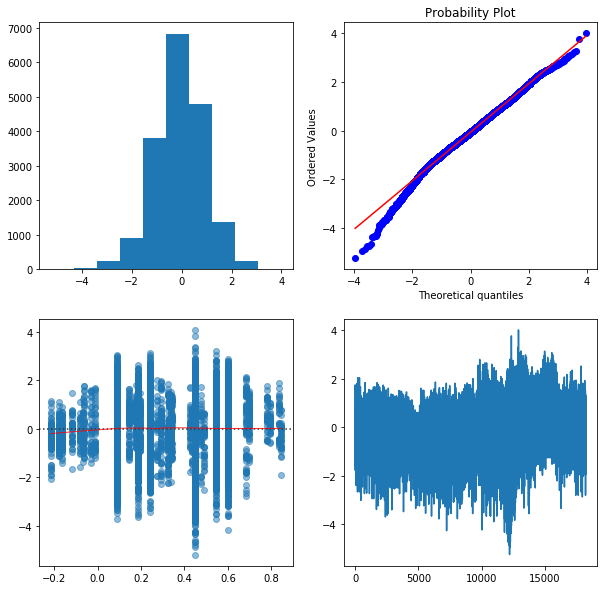

In [59]:
Model_Diagnostic(model, X[backward_features], data['Date'])
# No obvious outlier, linear trend and normal assumption for Wald test is not violated.

## Bootstrap 

In [60]:
Bootstrap(X[backward_features], y)
# The bias and standard error are very small and it shows that the model estimation is accuracy.

,Original,Bias,Standard Error
const,0.089966,-0.000120,0.002507
organic,0.357362,0.000157,0.002847
DallasFtWorth,-0.270202,-0.000041,0.008049
HartfordSpringfield,0.247703,-0.000197,0.007732
Houston,-0.305204,-0.000124,0.009694
SanFrancisco,0.235428,0.000379,0.011110
SouthCentral,-0.254263,0.000097,0.007800
Autumn,0.151312,0.000133,0.003824
Summer,0.097938,0.000013,0.003442


# Interpretation

1. We have 95\% confident that the average price is at least 42.2\% to at most 43.8\% higher on average if the avocado is organic compared to conventional one, given the region (Dallas-Fort Worth, Hartford–Springfield, Houston, San Francisco, South Central or other regions) is the same and the season (Autumn, Summer or other seasons) is the same.
2. We have 95\% confident that the average price is at least 22.0\% to at most 25.3\% lower on average if the avocado is sold in Dallas-Fort Worth compared to other regions, given the type of avocado (organic or conventional) is the same and the season (Autumn, Summer or other seasons) is the same.
3. We have 95\% confident that the average price is at least 25.4\% to at most 30.9\% higher on average if the avocado is sold in Hartford–Springfield compared to other regions, given the type of avocado (organic or conventional) is the same and the season (Autumn, Summer or other seasons) is the same.
4. We have 95\% confident that the average price is at least 24.7\% to at most 27.9\% lower on average if the avocado is sold in Houston compared to other regions, given the type of avocado (organic or conventional) is the same and the season (Autumn, Summer or other seasons) is the same.
5. We have 95\% confident that the average price is at least 23.9\% to at most 29.3\% higher on average if the avocado is sold in San Francisco compared to other regions, given the type of avocado (organic or conventional) is the same and the season (Autumn, Summer or other seasons) is the same.
6. We have 95\% confident that the average price is at least 20.8\% to at most 24.1\% lower on average if the avocado is sold in San Francisco compared to other regions, given the type of avocado (organic or conventional) is the same and the season (Autumn, Summer or other seasons) is the same.
7. We have 95\% confident that the average price is at least 15.5\% to at most 17.2\% higher on average if the avocado is sold in Autumn compared to Spring and Winter, given the type of avocado (organic or conventional) is the same and the region (Dallas-Fort Worth, Hartford–Springfield, Houston, San Francisco, South Central or other regions) is the same.
8. We have 95\% confident that the average price is at least 9.53\% to at most 11.1\% higher on average if the avocado is sold in Summer compared to Spring and Winter, given the type of avocado (organic or conventional) is the same and the region (Dallas-Fort Worth, Hartford–Springfield, Houston, San Francisco, South Central or other regions) is the same.

# Conclusion

1. The ratio of the scaled deviance to df is close to 1. The lack of fit is not significant. The perdiction accuracy is not bad although the RMSE is larger than that of linear regression model.
2. The collinearity problem is not significant as all the vif are close to 1.

# Further Work

1. The regions seem to be randomly drawn. We can fit a generalized linear mixed model to model the random effect.